In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

Load the dataset:

In [ ]:

Final_df = pd.read_csv(r"C:\Users\Dell\Downloads\Iris_Dataset_encoded_by_Gaussian_receptive_fields_for_SNN.csv")
Final_df = Final_df.iloc[:,1:]
#remove first column from dataset

In [5]:
def model_data(ind, ind_type, lat_ne, start, end):
    
    train_stack = np.vstack((
        lat_ne[ind_type[ind, 0] + start:ind_type[ind, 0] + end],
        lat_ne[ind_type[ind, 1] + start:ind_type[ind, 1] + end],
        lat_ne[ind_type[ind, 2] + start:ind_type[ind, 2] + end]
        ))
    train_stack = np.where(train_stack > 0, train_stack, 0)
    #ensures negative values are converted to 0, only positive values
    return train_stack

#ind specifies the class index (0,1,2)
#lat_ne stores the encoded iris datset 
#ind_type is a matrix 3*3 that maps which indices belongs to which class
# start and end defines the range of samples taken from each class


In [21]:
# Experiment 1:printing the extracted data
train_stack = model_data(0, ind_type, lat_ne, 0, 20)
print(train_stack.shape)  # Check shape
print(train_stack[:5])    # Print first 5 samples


(60, 40)
[[0.00000000e+00 0.00000000e+00 1.00000000e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.50646406e-01
  3.93469340e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.64664717e-01 5.57960288e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.93469340e-01 7.50646406e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.64664717e-01 8.64664717e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 8.64664717e-01 1.99258149e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.64664717e-01 5.57960288e-01 0.00000000e+00 0.00000000e+0

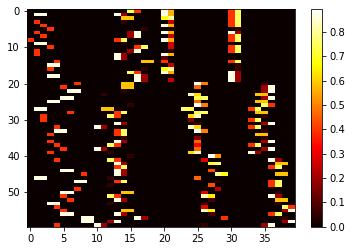

In [22]:
# Visualize neuron activation
import matplotlib.pyplot as plt
plt.imshow(train_stack, cmap='hot', aspect='auto')
plt.colorbar()
plt.show()


here black means neuron are inactive, red high potential, yellow firing

---------------------------------------------------------------------------------------------------------------------------------------------

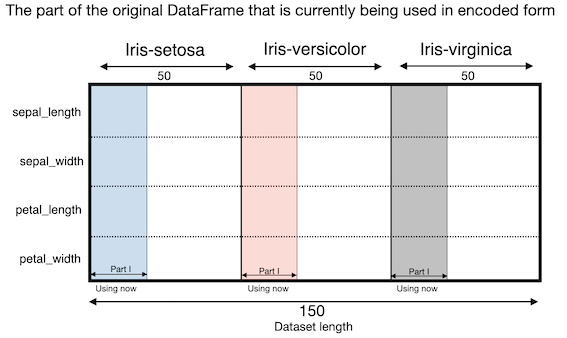

This block trains synaptic weights using a spike-based learning rule:

1. Extracts encoded neuron activations for training.
2. Applies non-linearity to activation values.
3. Updates synaptic weights iteratively, ensuring they remain positive.
4. Stores final weights for each class.

In [28]:
lat_ne = np.transpose(Final_df.values)
ind_type = np.array(([0, 50, 100], [50, 100, 0], [100, 0, 50]))
list_weight = np.zeros((3,40))#intial weight are 3 rows and 40 column input 0

for ind in range(3):#per class
    
    train_stack = model_data(ind, ind_type, lat_ne, 0, 20)#takes 20 samples for training
    tr_ar = np.where(np.transpose(train_stack) > 0, 2 * (1 - np.transpose(train_stack)), 0)
    #here if x>0 replace it with 2(1-x) and if x<=0 set it to 0

    #modify the last 20 columns
    tr_ar[:, 20:] = tr_ar[:, 20:] * (-1)

    #convert ot Dataframe and computes sum
    tr_ar = pd.DataFrame(tr_ar)
    tr_ar[20] = tr_ar.iloc[:,:20].sum(axis = 1) + 0.1 #column 20 is filled with row-wise sum of first 20 columns+ small offset 0.1

    #convert to numpy
    tst_ar = np.float64(np.transpose(np.array(tr_ar.iloc[:,20:])))
    

    #hebbian-like weight updates
    for i in range(1, len(tst_ar)):
        
        tst_ar[0][((np.round(tst_ar[0], 4) > 0.1) & (tst_ar[i] == 0))] += - np.float64(
            np.sum(tst_ar[i][np.round(tst_ar[0], 4) > 0.1]) / len(tst_ar[0][((
                np.round(tst_ar[0], 4) > 0.1) & (tst_ar[i] == 0))]))
        
        #Adjust weights negatively using an average correction
        tst_ar[0][np.round(tst_ar[0], 4) > 0.1] += tst_ar[i][np.round(tst_ar[0], 4) > 0.1]
        #Adds contributions from tst_ar[i] prevents weight from going below 0.1
        tst_ar[0][tst_ar[0] < 0.1] = 0.1
        
        #stores the final weight
    list_weight[ind, :] = tst_ar[0]

list_weight

array([[ 6.32765134,  9.87105956,  8.84511981,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         2.92858219,  7.46764082,  9.63385354,  3.93701917,  5.11459003,
         9.28614898, 24.82172975,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
        22.32748549, 20.18358506,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ],
       [ 0.1       ,  0.1       ,  0.1       ,  7.07935274,  3.98891031,
         4.65097619,  4.98755772,  0.1       ,  0.1       ,  0.1       ,
         8.02471674, 10.06988848,  0.1       ,  3.97558974,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  6.75899905, 12.65014928,
        17.92551459,  0.1       ,  0.1       ,  0.

In [29]:
print("Train Stack Shape:", train_stack.shape)
print("Transformed Array (tr_ar) Shape:", tr_ar.shape)
print("Test Array (tst_ar) Shape:", tst_ar.shape)
print("Weight Matrix:", list_weight)


Train Stack Shape: (60, 40)
Transformed Array (tr_ar) Shape: (40, 60)
Test Array (tst_ar) Shape: (40, 40)
Weight Matrix: [[ 6.32765134  9.87105956  8.84511981  0.1         0.1         0.1
   0.1         0.1         0.1         0.1         0.1         0.1
   0.1         0.1         0.1         2.92858219  7.46764082  9.63385354
   3.93701917  5.11459003  9.28614898 24.82172975  0.1         0.1
   0.1         0.1         0.1         0.1         0.1         0.1
  22.32748549 20.18358506  0.1         0.1         0.1         0.1
   0.1         0.1         0.1         0.1       ]
 [ 0.1         0.1         0.1         7.07935274  3.98891031  4.65097619
   4.98755772  0.1         0.1         0.1         8.02471674 10.06988848
   0.1         3.97558974  0.1         0.1         0.1         0.1
   0.1         0.1         0.1         0.1         0.1         6.75899905
  12.65014928 17.92551459  0.1         0.1         0.1         0.1
   0.1         0.1         0.1        11.38320978 13.14552299 2

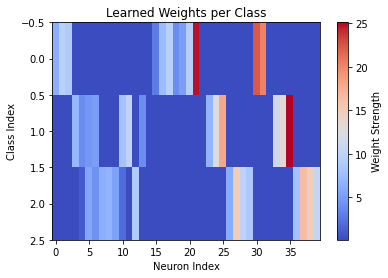

In [30]:
#ploting the weight distribution
import matplotlib.pyplot as plt

plt.imshow(list_weight, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Weight Strength")
plt.xlabel("Neuron Index")
plt.ylabel("Class Index")
plt.title("Learned Weights per Class")
plt.show()


In [ ]:
#Changing the training sample size
#train_stack = model_data(ind, ind_type, lat_ne, 0, 30)  # Use 30 samples instead of 20


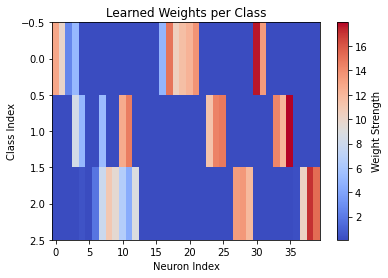

We have obtained our first set of weights! Let's write a function for our neuron that takes into account the synaptic weights and spike timings of presynaptic neurons. Then we will see how the membrane potential of each postsynaptic neuron behaves.

But first, let's introduce the formula for changing the membrane potential of a postsynaptic neuron. Simply put: a spike with the weight of the synapse arrives at the postsynaptic neuron -> the membrane potential of the postsynaptic neuron increases, and if no spikes arrive, the potential drops to its minimum level (in our case, this is 0) - this logic is visible in the following formula:

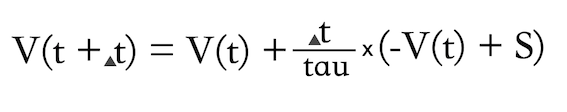

this formula is a slightly modified and simplified version of formula from [10], but all the logic of the classic LIF neuron is preserved here. In my formula, the resting potential is absent because I assume it to be equal to 0. Input parameters such as tau, dt, Vmin can be chosen to approximate the model to the biological neuron model. In this case, I do not have such a task, so the parameters are chosen to be as clear and functional as possible. Now let's implement this logic in code:

LIF Function

In [36]:
def LIF_SNN(n, l, data, weight, v_spike):
    
    V_min = 0 #initial membrane potential
    V_spike = v_spike #threshold potential for firing a spike
    r = 5 #scaling factor for spike influence
    tau = 2.5 #time_constant
    dt = 0.01 #time step for simulation
    t_max = 10 #Max simulation time
    time_stamps = t_max / dt # total number of time steps
    time_relax = 10 #refractory period (time spike when neuron resets)

    #initializing membrane potential and spike timing
    v = np.zeros((n, l, int(time_stamps))) #stores membrane potentials over time
    t_post = np.zeros((n, l)) #last spike timing for all neurons
    t_post_ = np.zeros((n, int(l / 3))) #tracks last spike time for a subset of neurons
    v[:, :, 0] = V_min #initialize membrane potential
    
    for n in range(n): #each neuron
        for u in range(l): #each input of neuron
            
            #Processing input spikes
            t = 0

            #here converting input spike times into binary spike trains
            f0 = (np.round(data[u][np.newaxis].T, 3) * 1000).astype(int)#convert the data array into integer spike times
            f1 = np.tile(np.arange(1000), (40, 1)) #generates a timeline to compare against
            f2 = np.where(((f1 == f0) & (f0 > 0)), 1, 0) # creating a binary spike train (1 if spike, 0 otherwise)
            f2 = f2 * weight[n][np.newaxis].T
            spike_list = np.sum(f2.copy(), axis = 0)
            # why? to encode continuous input into a spike based representation

            #Handling spiking behaviour
            for step in range(int(time_stamps) - 1):
                if v[n, u, step] > V_spike:#when a neuron spikes
                    t_post[n, u] = step #spike time is recorded
                    v[n, u, step] = 0 #reset membrance potential
                    t = time_relax / dt #start refractory period

                    #handling refractory period
                elif t > 0:
                    v[n, u, step] = 0 # keep potential at 0 during relaxation
                    t = t - 1 # decrease relaxation time
                
                #membrane potential update(LIF Model)
                v[n, u, step + 1] = v[n, u, step] + dt / tau * (-v[n, u, step] + r * spike_list[step])
        # storing spike timing: extract a subset of spike times, likely used for classification or further processing
        t_post_[n, :] = t_post[n, n * int(l / 3):n * int(l / 3) + int(l / 3)]
    
    return v, t_post_, t_post

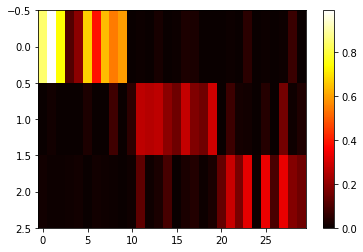

In [37]:
import matplotlib.pyplot as plt
plt.imshow(v[:, :, -1], cmap='hot', aspect='auto')
plt.colorbar()
plt.show()


Function for visualizing spike moments of postsynaptic neurons:

In [8]:
def spike_plot(spike_times, one_per, n, cur_type):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (25, 10))
    
    if one_per:
        k, t, a  = 1, n, 0
        cur = cur_type
    else:
        k, t, a = len(spike_times[0]), 0, 1
        cur = 1
        
    spike_times[spike_times == 0] = np.nan
    di = {0: 'blue', 1: 'red', 2: 'black'}
    di_t = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
    p = 0
    
    for ax in [ax1, ax2, ax3]:
        for i in range(k * t, k + t):
            ax.vlines(x = spike_times[p, i] / 100 + i * a * 10, ymin = 0.0, ymax = 1.1, 
                       colors = di[p], ls = '-', lw = 3)
            ax.set_ylabel(f'Neuron {p + 1} \n {di_t[p]}', fontsize = 15)
            
        if one_per:
            ax.axvspan(0, int(k * 10), color = di[cur - 1], alpha = 0.05, label = di_t[cur - 1])
            ax.margins(0)
        else:
            ax.axvspan(0, int(k * 10 / 3), color = di[0], alpha = 0.05, label = di_t[0])
            ax.axvspan(int(k * 10 / 3), int(k * 10 * 2 / 3), color = di[1], alpha = 0.05, label = di_t[1])
            ax.axvspan(int(k * 10 * 2 / 3), int(k * 10 * 3 / 3), color = di[2], alpha = 0.05, label = di_t[2])
            ax.set_xlim(0, k * 10)
            ax.margins(0)
            
        p += 1
        
    
    if one_per:
        plt.suptitle(f' \n\n Moment of spike of postsynaptic neurons for train period {n}', fontsize = 20)
        plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 1.9), loc = 'upper left',
               fontsize = 15, title_fontsize = 15)
    else:
        plt.suptitle(f' \n\n Moment of spike of postsynaptic neurons on the used part of the dataset', fontsize = 20)
        plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 2.1), loc = 'upper left',
               fontsize = 15, title_fontsize = 15)
    
    plt.xlabel('Time (ms)', fontsize = 15)
    plt.show()

Function for visualizing membrane potential of each postsynaptic neuron:

In [9]:
def v_plot(v):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (25, 10))
    k = len(v[0,:,:])
    di = {0: 'blue', 1: 'red', 2: 'black'}
    di_t = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
    p = 0
    
    for ax in [ax1, ax2, ax3]:
        for i in range(k):
            ax.plot(np.arange(i * 10, (i + 1) * 10, 0.01), v[p, i, :], di[p], linewidth = 1)
            ax.set_ylabel(f' Neuron {p + 1} \n {di_t[p]} \nV (mV)', fontsize = 15)

        ax.axvspan(0, int(k * 10 / 3), color = di[0], alpha = 0.05, label = di_t[0])
        ax.axvspan(int(k * 10 / 3), int(k * 10 * 2 / 3), color = di[1], alpha = 0.05, label = di_t[1])
        ax.axvspan(int(k * 10 * 2 / 3), int(k * 10 * 3 / 3), color = di[2], alpha = 0.05, label = di_t[2])
        ax.margins(0)

        p += 1
    
    plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 2), loc = 'upper left', fontsize = 15, title_fontsize = 15)
    plt.xlabel('Time (ms)', fontsize = 15)
    plt.suptitle(' \n Activity of postsynaptic neurons on the used part of the dataset \n (Membrane potential)', fontsize = 20)

Accuracy function. If multiple postsynaptic neurons generate spikes during one period, the postsynaptic neuron that generated the spike first is considered to have fired:

In [10]:
def accuracy_snn(spike_time, start, end, ind_type, ind):
    
    target_type_total = np.repeat(np.array([1,2,3]),50)
    target_type = np.vstack((target_type_total[ind_type[ind, 0] + start:ind_type[ind, 0] + end],
                            target_type_total[ind_type[ind, 1] + start:ind_type[ind, 1] + end],
                            target_type_total[ind_type[ind, 2] + start:ind_type[ind, 2] + end])).flatten()
    
    spike_time_ = np.where(spike_time > 0, np.array(([1], [2], [3])), np.nan)
    final_test = np.full([len(spike_time[0])], np.nan).astype(int)
    for i in range(len(spike_time[0])):
        try:
            final_test[i] = spike_time_[:, i][spike_time[:, i] == np.min(spike_time[:, i][spike_time[:, i] > 0])][0]
        except:
            final_test[i] = 0
    
    ac = np.sum(np.where(final_test == target_type, 1, 0)) / len(target_type)

    return final_test, target_type, print('accur.:', np.round(ac * 100, 2), '%')

We adjusted and increased the weights on the first 20 instances of each type for each postsynaptic neuron, resulting in three sets of weights. Let's examine the membrane potential profile of each postsynaptic neuron with these obtained weights on the same first part of the training set. At this stage, we will not limit the membrane potential to a threshold level, choosing it to be equal to 100:

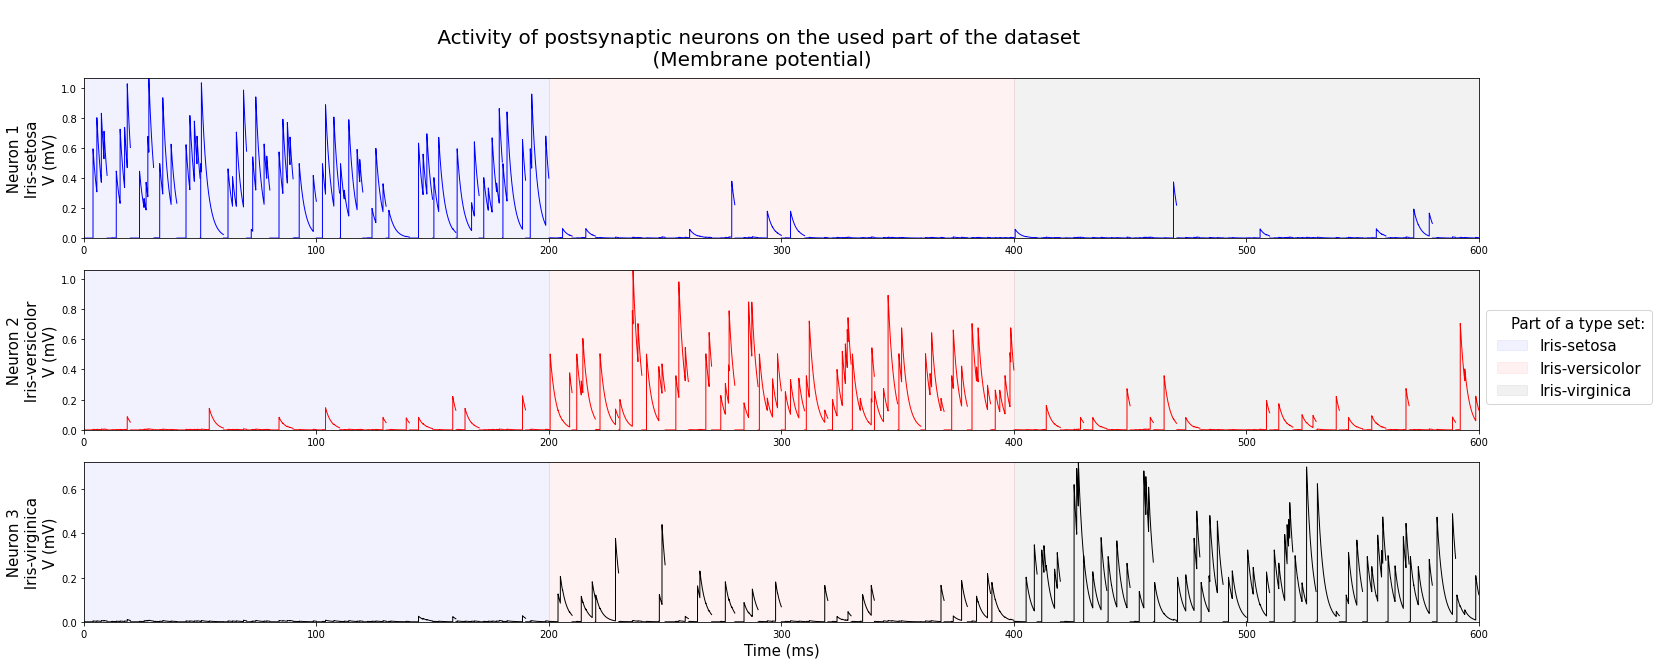

In [11]:
train_stack = model_data(0, ind_type, lat_ne, 0, 20)
res = LIF_SNN(3, 60, train_stack, list_weight, 100)
v = res[0]

v_plot(v)

Overall, it looks good, with each postsynaptic neuron's activity area clearly visible. The membrane potential profile of the first neuron looks the best, while neurons 2 and 3 are more responsive to "foreign" spikes that should not significantly change their potentials - this could lead to incorrect classification. Let's look at the spike times and accuracy at this stage with a threshold voltage value of 0.25:

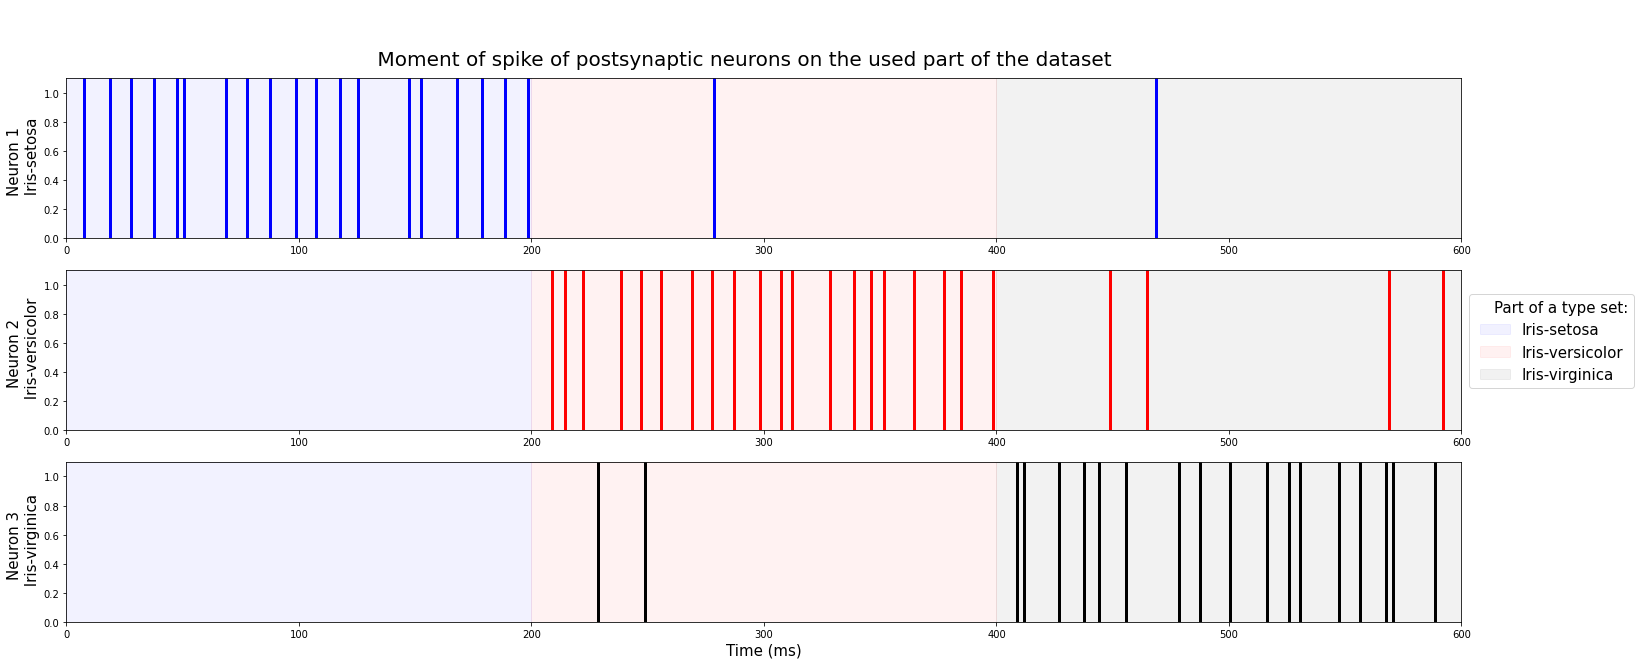

accur.: 93.33 %


In [12]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 0, 20, ind_type, 0)[2]


The accuracy is good! Let's examine a few periods where one of the postsynaptic neurons has false activations. We'll try to understand what's happening and how it affects accuracy.

Let's look at the last false spike of the first postsynaptic neuron, which occurs in period 46 of the first part of training:

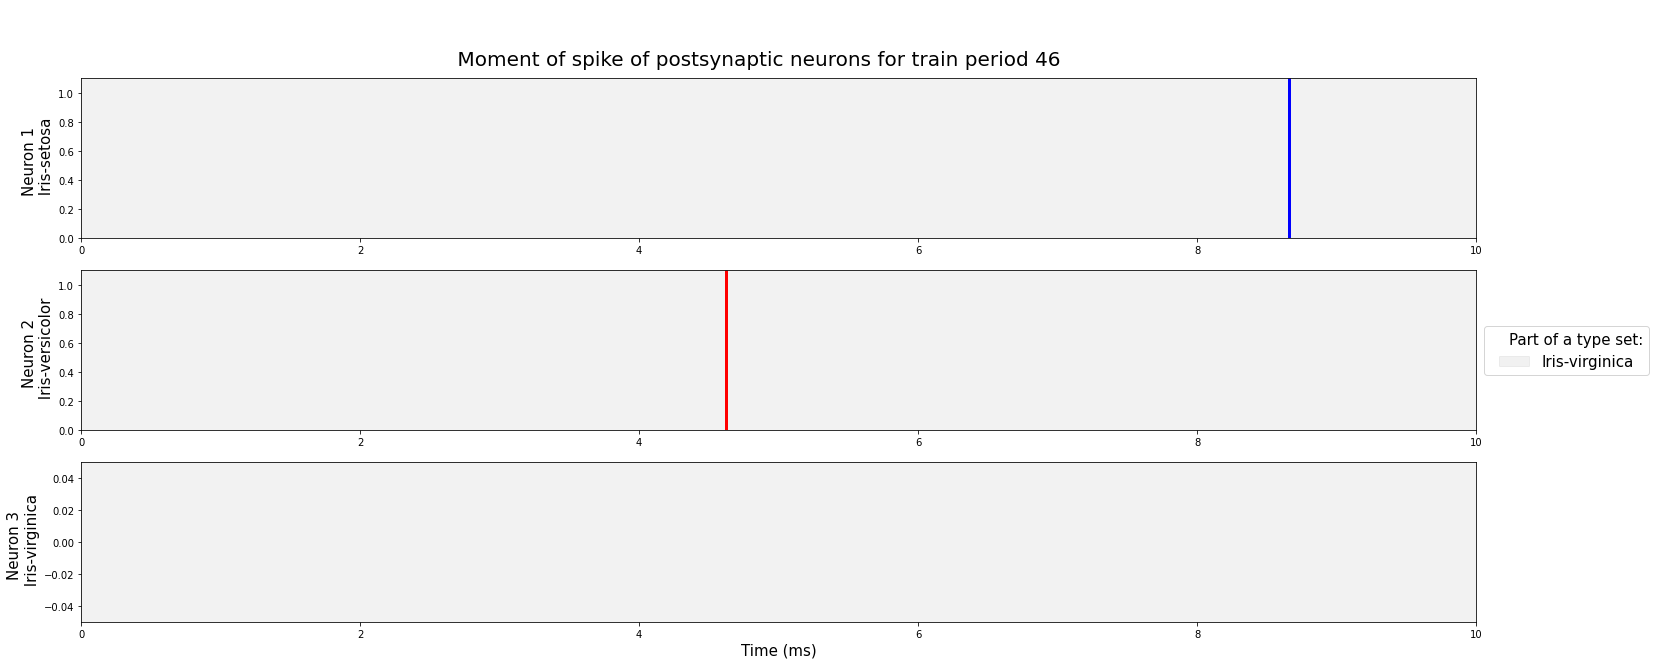

In [13]:
spike_plot(spike_time, True, 46, 3)

Together with the first incorrect spike, the second postsynaptic neuron spikes falsely, while the necessary third neuron remains silent. In this case, the second neuron will be recognized as having fired because it generated a spike earlier than the first - this is an error that reduces accuracy.

Let's examine the second false spike of the third postsynaptic neuron, which occurs in period 24 of the first part of training:

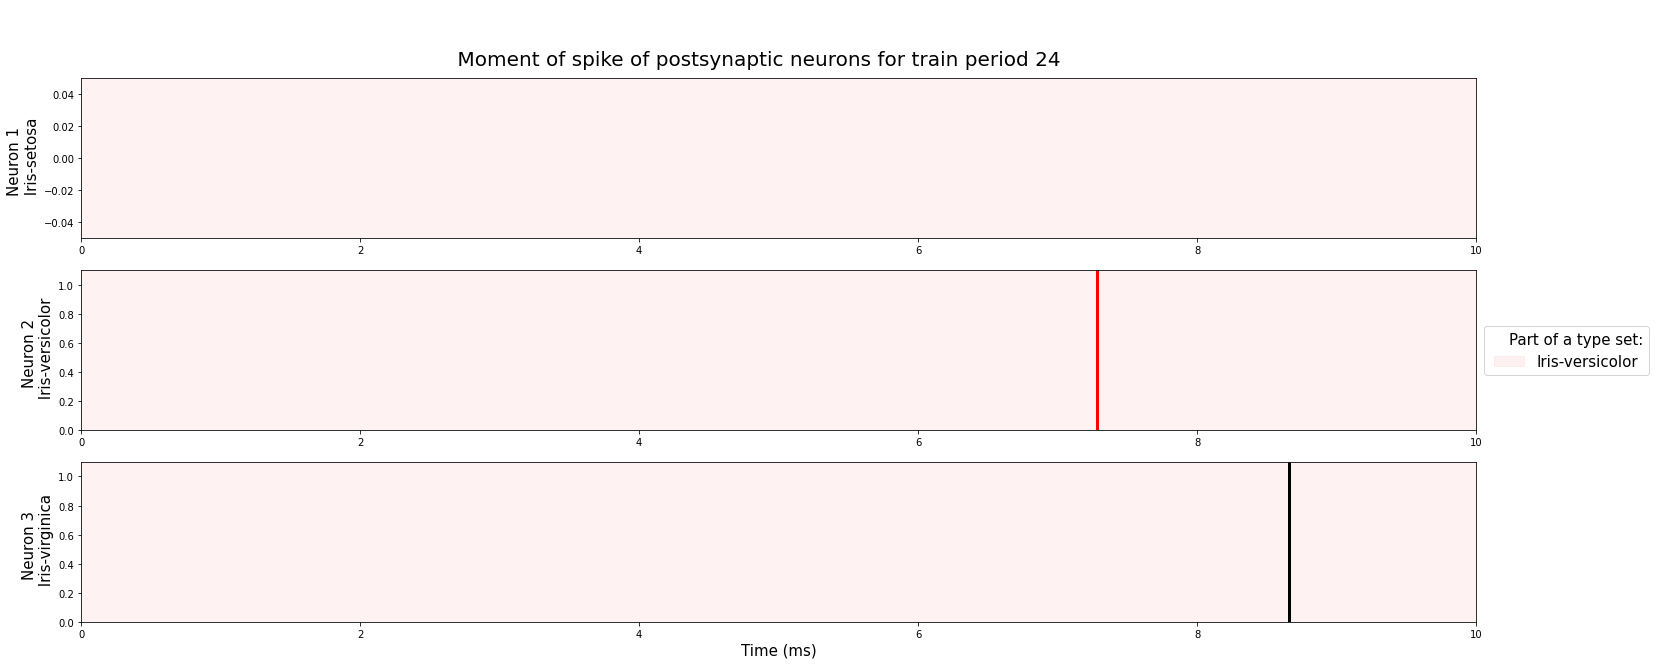

In [14]:
spike_plot(spike_time, True, 24, 2)

Together with the third spike in this period, the "correct" second postsynaptic neuron fires. In this case, because the second neuron fired earlier than the false third neuron, it will be considered as having fired in the current period and no error will occur.

Overall, things are going well, so let's smoothly transition to the second part of training. To do this, we take the next 20 examples of each type:

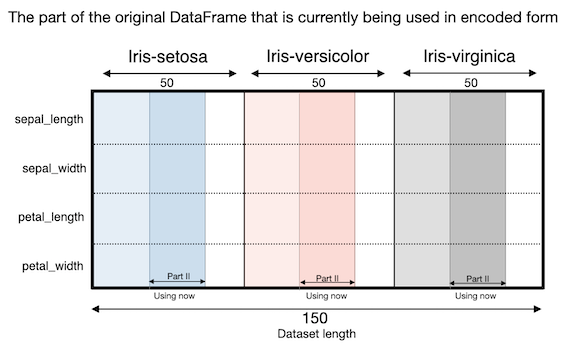

At this stage, we are training on the next set of input data using local STDP learning. Before we proceed, let's see what the result and accuracy would be if we applied the current weights to the second training set:

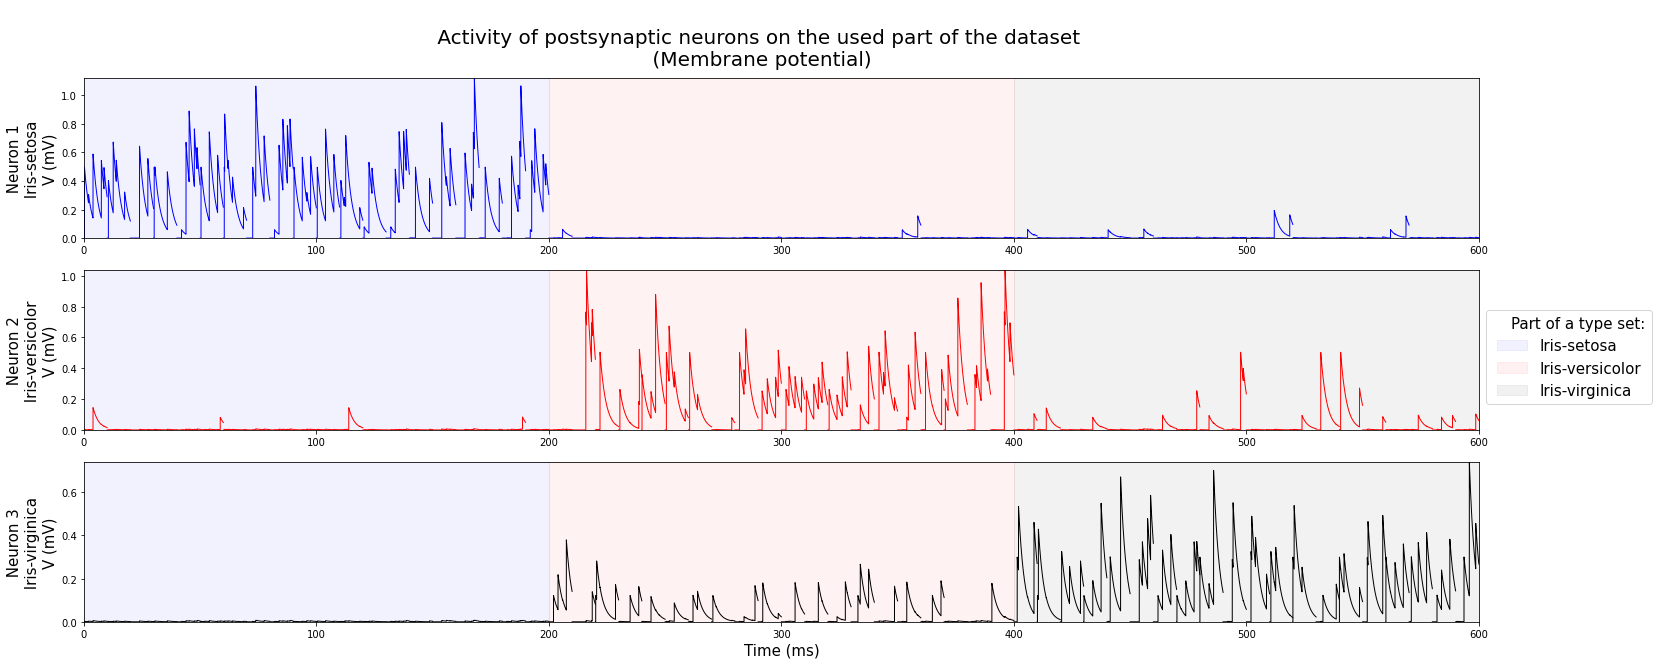

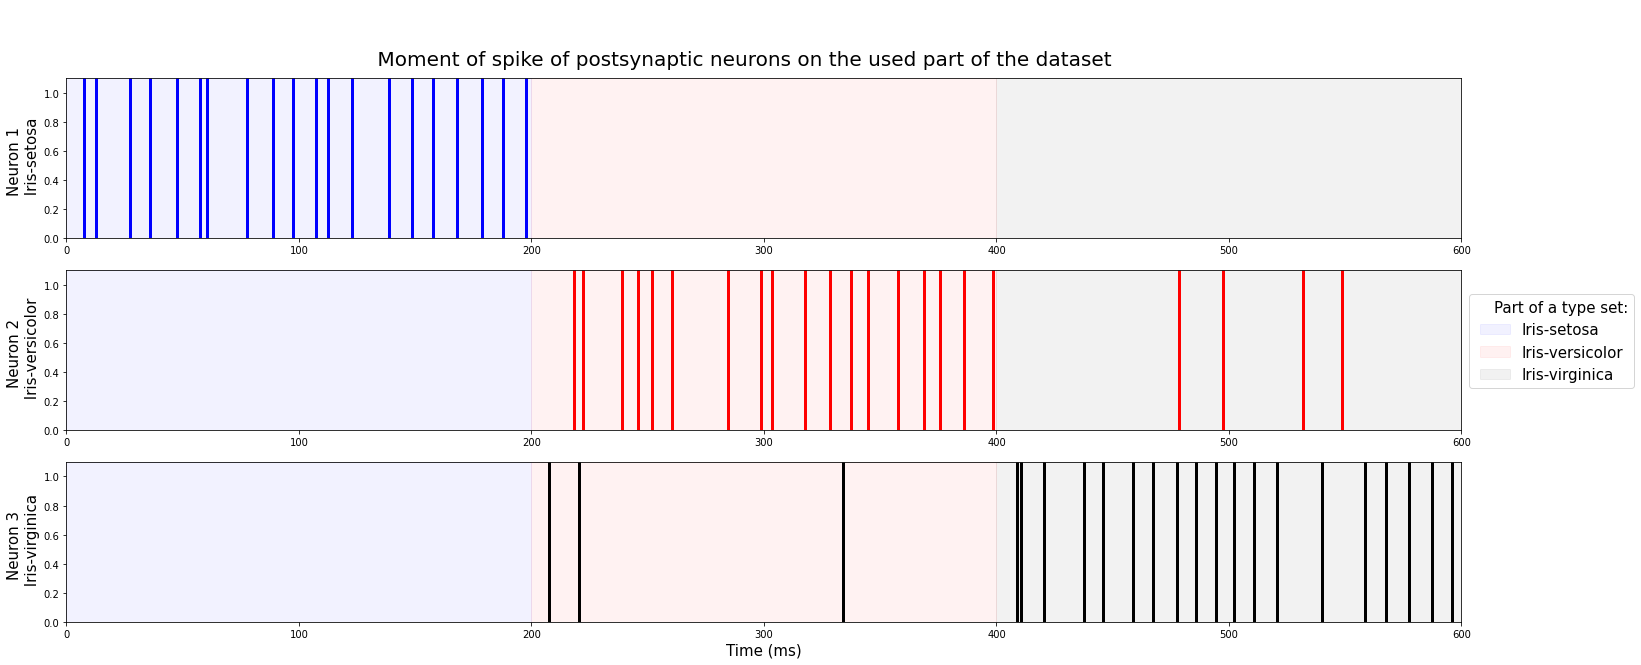

accur.: 91.67 %


In [15]:
train_stack = model_data(0, ind_type, lat_ne, 20, 40)
res = LIF_SNN(3, 60, train_stack, list_weight, 100)
v = res[0]

v_plot(v)
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 20, 40, ind_type, 0)[2]

Overall, the profile is similar to the profile of the first set. The accuracy has slightly decreased - a expected result.

Now it's time to adjust the weights using classical STDP for the second part of the training set. A few words about the formula and meaning of the used STDP approach. In short: presynaptic neurons generate spikes -> the membrane potential of the postsynaptic neuron increases and reaches a threshold value -> the postsynaptic neuron generates a spike -> if the period has not ended, presynaptic neurons can continue to generate spikes that are no longer needed -> it is necessary to strengthen the weights of presynaptic neurons that fired before the postsynaptic neuron generated a spike and decrease the weights of those that fired after.

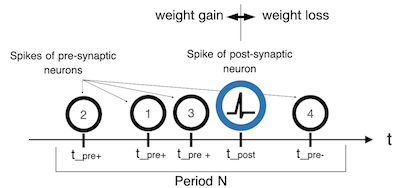

To apply STDP, we will record the spike timings of each postsynaptic neuron at a threshold value of 0.25, obtaining values for t_post. We already have the values for t_pre (latency) which we calculated earlier. We will calculate the weight change for each presynaptic neuron for each postsynaptic neuron using the following formulas:

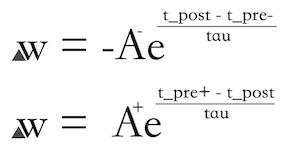

Depending on the presynaptic neuron's latency their the weights will be adjusted towards growth or reduction. The constants A+ and A- are selected individually for each task: if the training set is large, a small value can be chosen, and vice versa for a small training set (as we have now). A+ and A- are usually expressed in terms of each other:

In [16]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
t_post = res[1]
A_p = 0.8
A_m = A_p * 1.1

for n in range(3):
    for u in range(20):
        
        t1 = np.round(train_stack[u + 10 * n] * 1000)
        t2 = t1.copy()
        
        t2[((t1 <= t_post[n, u]) & (t1 > 0))] = A_p * np.exp((t1[((t1 <= t_post[n, u]) & (t1 > 0))] - t_post[n, u]) / 1000)
        t2[((t1 > t_post[n, u]) & (t1 > 0))] = - A_m * np.exp((t_post[n, u] - t1[((t1 > t_post[n, u]) & (t1 > 0))]) / 1000)
        
        list_weight[n, :] += t2
        
list_weight[list_weight < 0] = 0
list_weight

array([[ 6.86283594, 13.14555881, 11.21855962,  0.        ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.        ,  3.46874653,
         8.10106089,  5.35787327,  9.09420293,  4.99738161,  5.91379042,
        12.86232196, 35.28699568,  0.        ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
        29.42315812, 33.23163288,  0.8992004 ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ],
       [ 0.84666134,  0.        ,  0.        ,  6.74229608,  2.22163186,
         3.82569237,  6.03148173,  0.1       ,  0.1       ,  0.1       ,
         8.02471674, 10.06988848,  0.89146427,  2.4844071 ,  0.        ,
         0.        ,  0.        ,  0.1       ,  1.19098518,  0.87791069,
         0.        ,  0.        ,  0.1       ,  6.75899905, 12.25004938,
        19.51810541,  2.64238288,  0.1       ,  0.

We have adjusted the weights, let's see how the accuracy of the model has now changed on the second set of training instances:

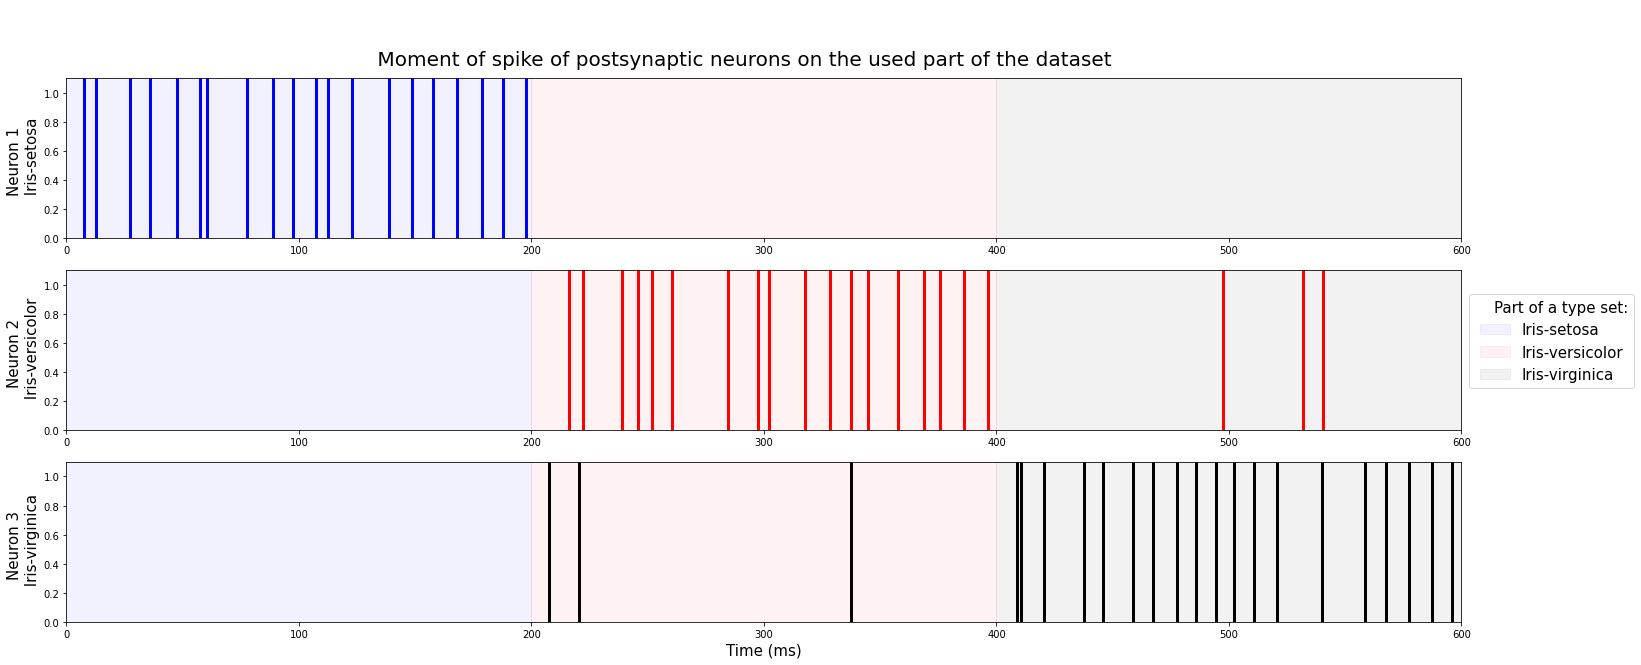

accur.: 93.33 %


In [17]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 20, 40, ind_type, 0)[2]

Great! It has increased to its previous level. Now let's check the classification accuracy on the entire training set (all first 40 instances of each class) using by this weights:

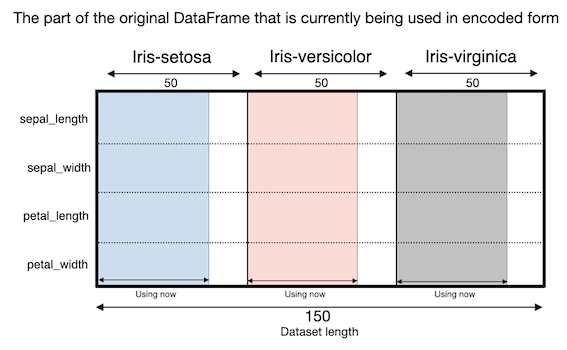

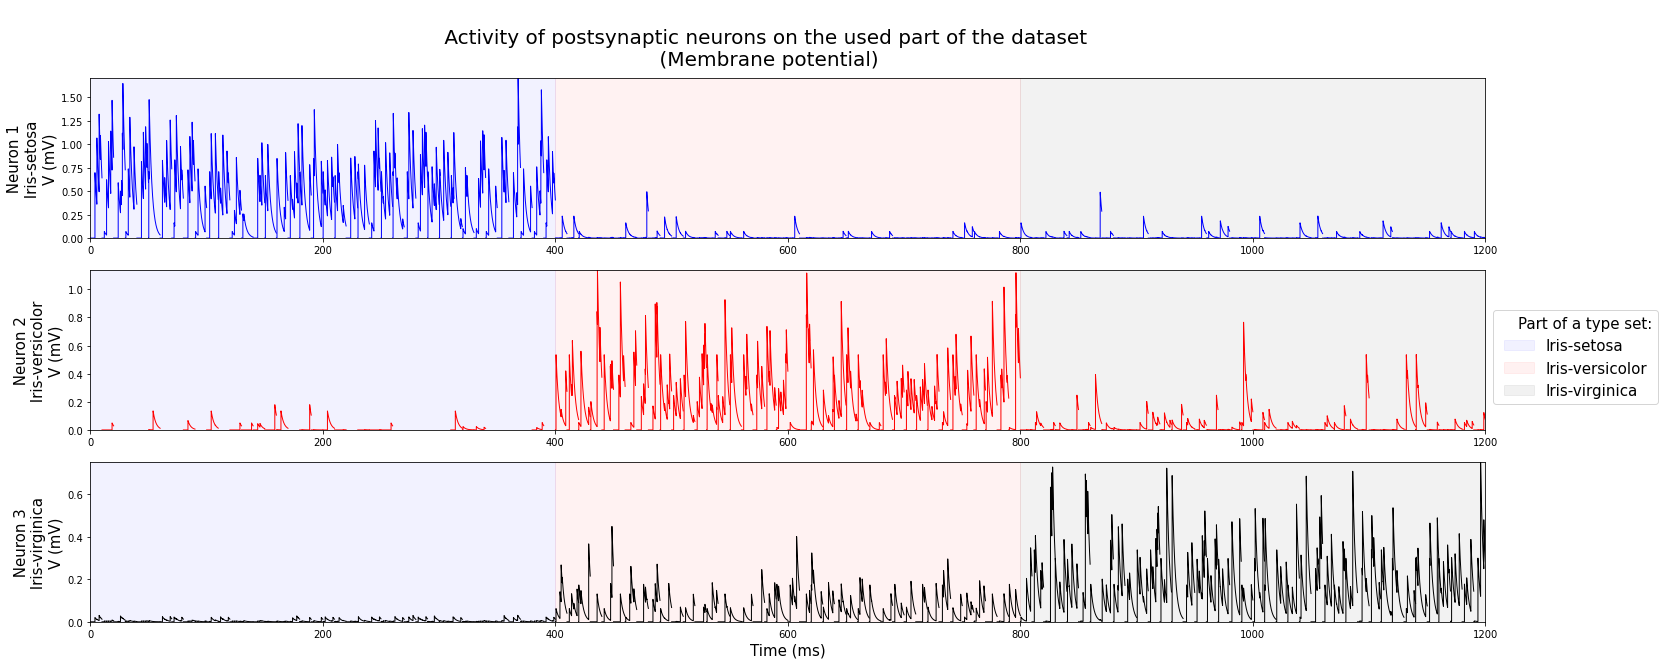

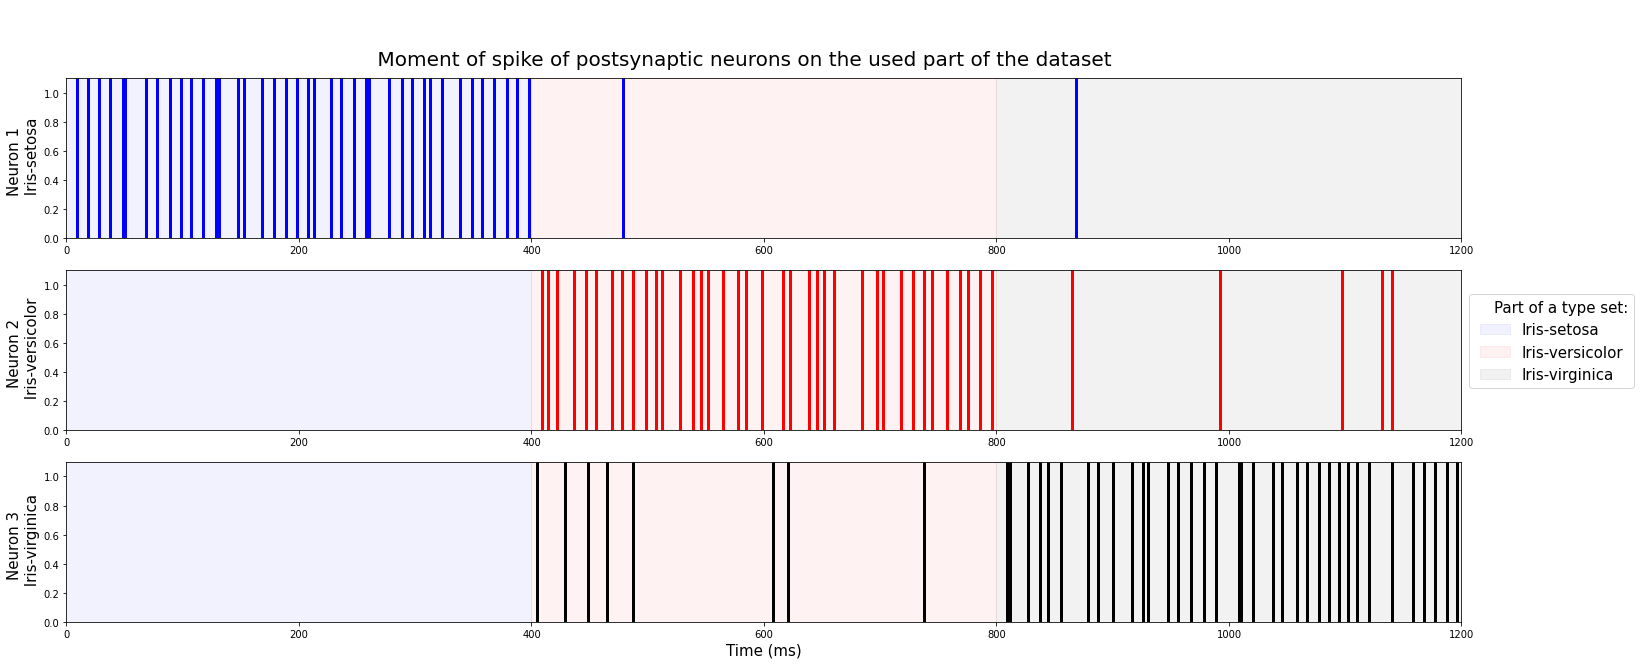

accur.: 92.5 %


In [18]:
train_stack = model_data(0, ind_type, lat_ne, 0, 40)
res = LIF_SNN(3, 120, train_stack, list_weight, 100)
v = res[0]

v_plot(v)
res = LIF_SNN(3, 120, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 0, 40, ind_type, 0)[2]

Overall, it's very good that the quality almost didn't decrease when the sample size was doubled. Although there are periods in which postsynaptic neurons sometimes fire at the wrong times, we still achieve high accuracy because the postsynaptic neuron that generated a spike earlier within one period is recognized as having fired.

Now let's run the network on the test set (the last 10 instances of each class):

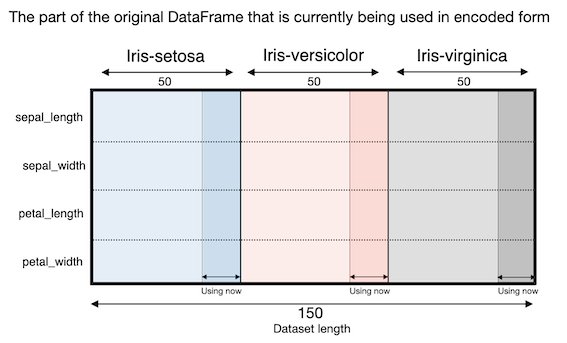

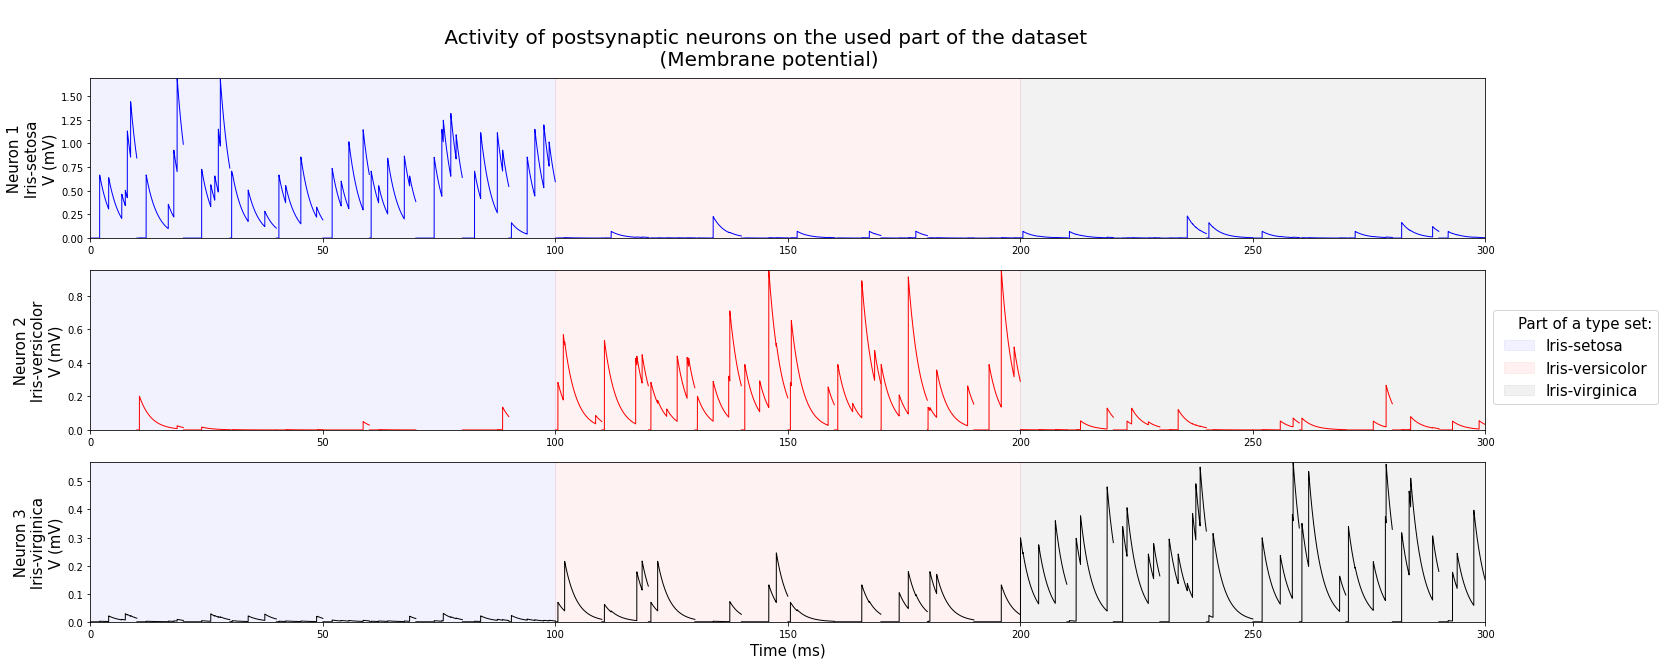

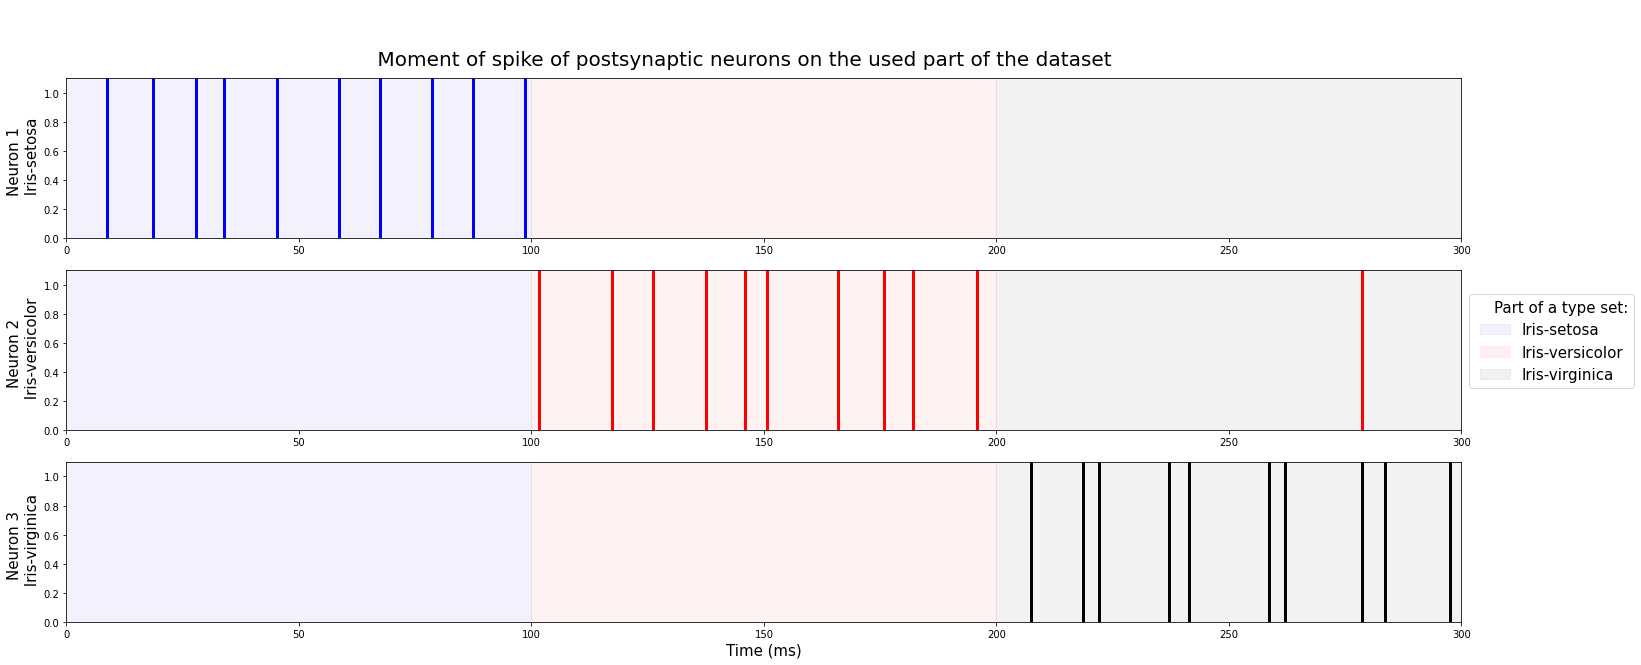

accur.: 100.0 %


In [19]:
train_stack = model_data(0, ind_type, lat_ne, 40, 50)
res = LIF_SNN(3, 30, train_stack, list_weight, 100)
v = res[0]
res = LIF_SNN(3, 30, train_stack, list_weight, 0.25)
spike_time = res[2]

v_plot(v)
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 40, 50, ind_type, 0)[2]

Accuracy is 100%!

There seems to be one false firing of the second postsynaptic neuron in period 27, let's examine it more closely:

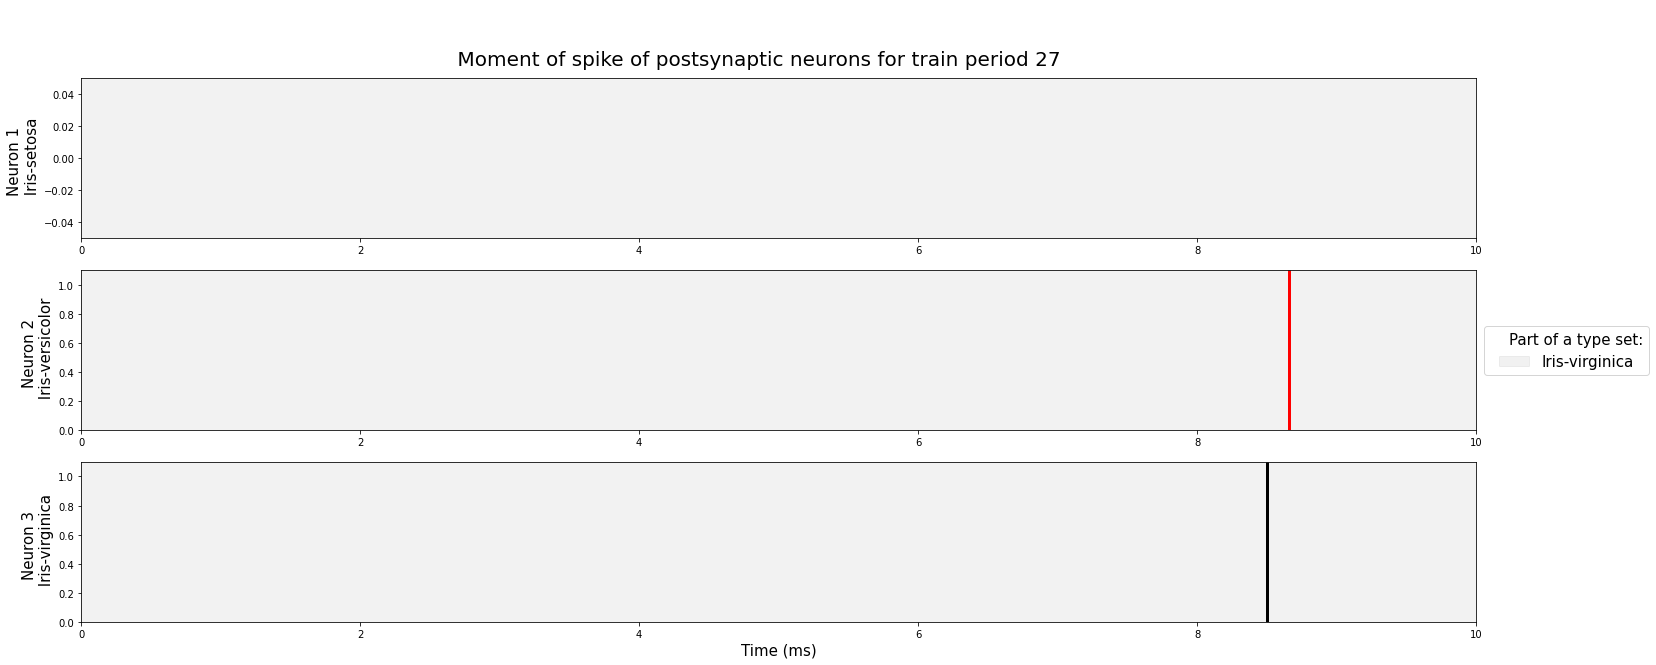

In [20]:
spike_plot(spike_time, True, 27, 3)

In this case, due to the fact that the third postsynaptic neuron fired before the false second one (8.50 mc vs 8.66 ms), it is considered to have fired in the current period and no error will occur.

Congratulations! we wrote a simple impulse neural model from scratch and learned how to encode data using Gaussian receptive fields using only NumPy.

**References**:

[1] Alexander Sboev, Danila Vlasov, Roman Rybka, Alexey Serenko, "[Spiking neural network reinforcement learning method based on Abstract temporal coding and STDP](https://www.sciencedirect.com/science/article/pii/S1877050918323950)", Procedia Computer Science Volume 145, 2018, Pages 458-463

[2] Stefan Schliebs, Nikola Kasabov, "[Evolving spiking neural networks: A Survey](https://www.researchgate.net/publication/257786595_Evolving_spiking_neural_networks_A_Survey)", Article in Evolving Systems, June 2013 DOI: 10.1007/s12530-013-9074-9

[3] M. Kiselev, "Spiking neural networks - Information Representation, Learning, Memory" (manuscript)

[4] Eugene M. Izhikevich, "[Simple Model of Spiking Neurons](https://www.izhikevich.org/publications/spikes.pdf)", IEEE TRANSACTIONS ON NEURAL NETWORKS, VOL. 14, NO. 6, NOVEMBER 2003

[5] Dmitry Ivanov, Aleksandr Chezhegov, Mikhail Kiselev, Andrey Grunin, Denis Larionov, "[Neuromorphic artificial intelligence systems](https://www.frontiersin.org/articles/10.3389/fnins.2022.959626/full)", Front. Neurosci., 14 September 2022, Sec. Neuromorphic Engineering, Volume 16 - 2022

[6] Laurent U Perrinet, Arnaud Delorme, Manuel Samuelides, Simon Jonathan Thorpe, "[Networks of Integrate-and-Fire Neuron using Rank Order Coding A: How to Implement Spike Time Dependent Hebbian Plasticity](https://www.researchgate.net/publication/220551941_Networks_of_Integrate-and-Fire_Neuron_using_Rank_Order_Coding_A_How_to_Implement_Spike_Time_Dependent_Hebbian_Plasticity)", June 2001, Neurocomputing 38-40:817-822, DOI:10.1016/S0925-2312(01)00460-X

[7] Senglan Li, Qiang Yu, "[New Efficient Multi-Spike Learning for Fast Processing and Robust Learning](https://www.researchgate.net/publication/342543443_New_Efficient_Multi-Spike_Learning_for_Fast_Processing_and_Robust_Learning)", April 2020Proceedings of the AAAI Conference on Artificial Intelligence 34(04):4650-4657, DOI:10.1609/aaai.v34i04.5896

[8] Gütig R, Sompolinsky H., "[The tempotron: a neuron that learns spike timing-based decisions](https://pubmed.ncbi.nlm.nih.gov/16474393/)", Nat Neurosci. 2006 Mar;9(3):420-8. doi: 10.1038/nn1643. Epub 2006 Feb 12. PMID: 16474393.

[9] Baktash Babadi, L. F. Abbott, "[Stability and Competition in Multi-spike Models of Spike-Timing Dependent Plasticity](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004750)", Published: March 3, 2016, https://doi.org/10.1371/journal.pcbi.1004750

[10] [Neuromatch Academy: Computational Neuroscience](https://compneuro.neuromatch.io/tutorials/intro.html)